In [7]:
# start here by entering a ticker symbol
ticker = "BAX"
# number of weeks to look back
weeks = 13
# and watch the magic happen below...
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from empyrical import max_drawdown, alpha, beta
from sklearn.preprocessing import MinMaxScaler
from src.asset_selector import AssetSelector
from src.indicators import Indicators
from util import time_formatter
from src.predictor import Predictor
from sklearn.cluster import KMeans
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import numpy as np
import configparser
import requests
import json
import time
import sys
import os
backdate = time_formatter(time.time() - (604800 * weeks))
config = configparser.ConfigParser()
try:
    config.read(os.path.relpath("config.ini"))
except FileExistsError as e:
    print("FileExistsError: {}".format(e))
    sys.exit(1)
alpaca_api = tradeapi.REST(
    base_url    = config["alpaca"]["APCA_API_BASE_URL"],
    key_id      = config["alpaca"]["APCA_API_KEY_ID"],
    secret_key  = config["alpaca"]["APCA_API_SECRET_KEY"],
    api_version = config["alpaca"]["VERSION"]
)
trading_account = alpaca_api.get_account()

selector            = AssetSelector(alpaca_api, edgar_token=None)
indicators          = Indicators(alpaca_api)
day_bars            = selector.get_barset(ticker, "day", backdate)
day_bars            = selector.extract_bar_data(day_bars, ticker)
minute_bars         = selector.get_barset(ticker, "minute", backdate)
minute_bars         = selector.extract_bar_data(minute_bars, ticker)
day_spy_bars        = selector.get_barset("SPY", "1D", backdate)
day_spy_bars        = selector.extract_bar_data(day_spy_bars, "SPY")
minute_spy_bars     = selector.get_barset("SPY", "minute", backdate)
minute_spy_bars     = selector.extract_bar_data(minute_spy_bars, "SPY")
ticker_cluster      = indicators.cluster_prep(ticker)
# TODO: Add new sets of bars (same ticker, differnt date) for validation of ML training

In [8]:
ticker_cluster.iloc[-1]
# Time to start using the most recent values of these indicators to make some trade decisions!!!!

time            2019-11-11 00:00:00-05:00
open                                78.32
high                                79.35
low                               78.2025
close                               78.86
volume                            2612695
up_move                              0.68
down_move                         -0.5225
DMp                                  0.68
DMm                                     0
ticker                                BAX
bb_up                             91.0197
bb_mid                            81.3332
bb_low                            71.6468
macd                             -2.16239
signal                            -2.1551
vwmacd                           -1.25224
vwsignal                         -1.40106
mfi                               34.6432
stoch                             25.1776
vzo                              -7.44699
apz_u                              80.591
apz_l                             74.7156
bb_up_ptc                     -0.0

# Exploratory graphs (using day bars)

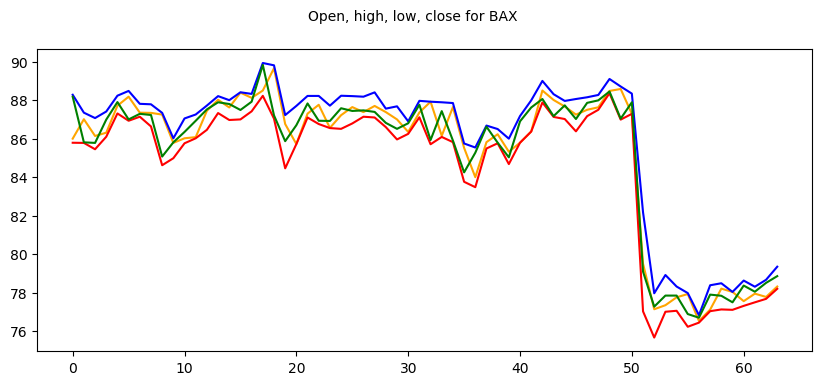

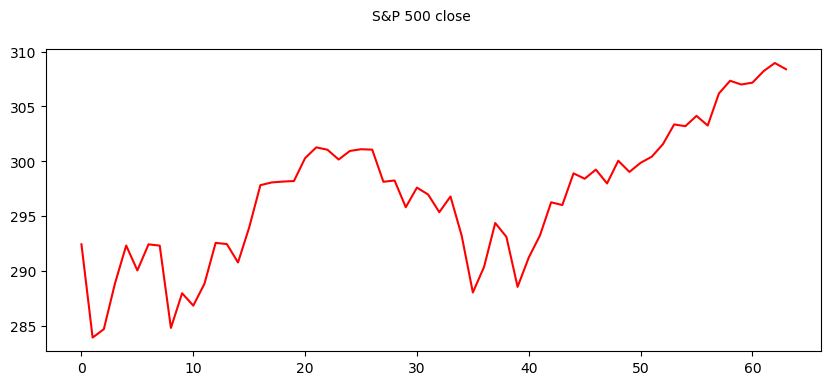

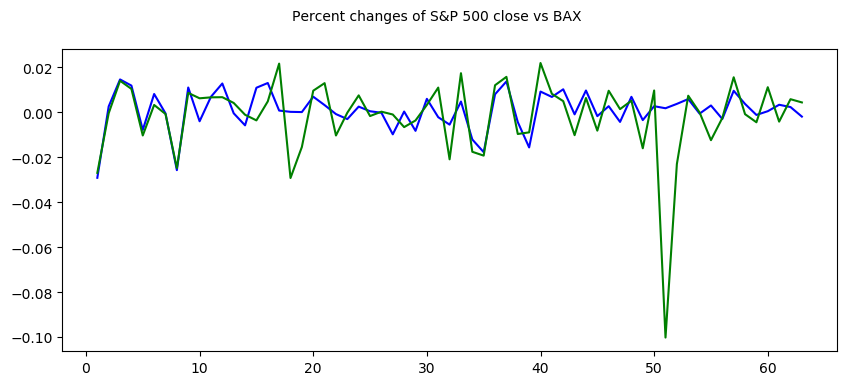

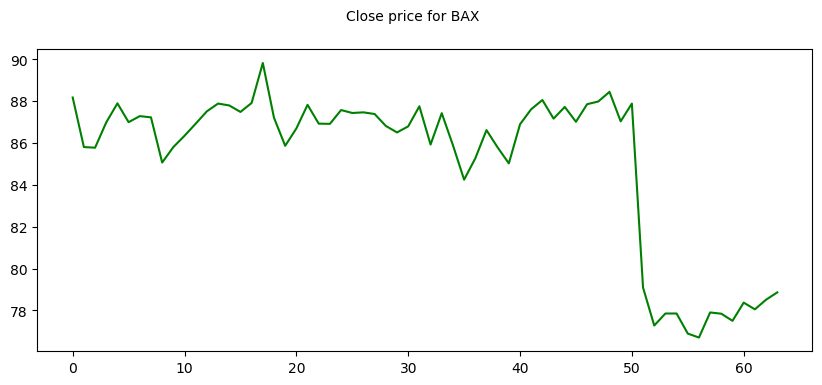

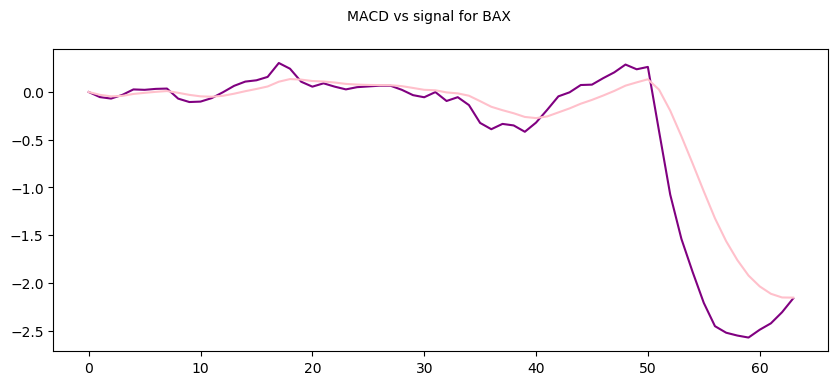

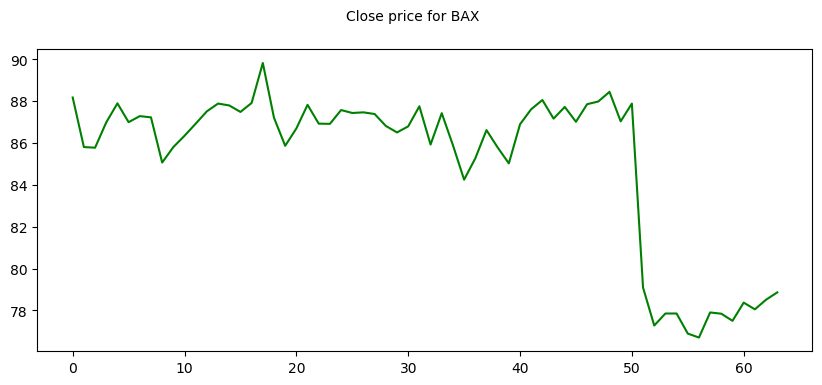

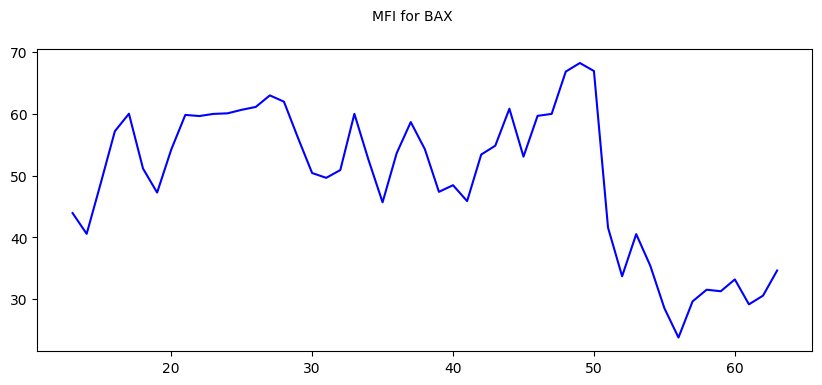

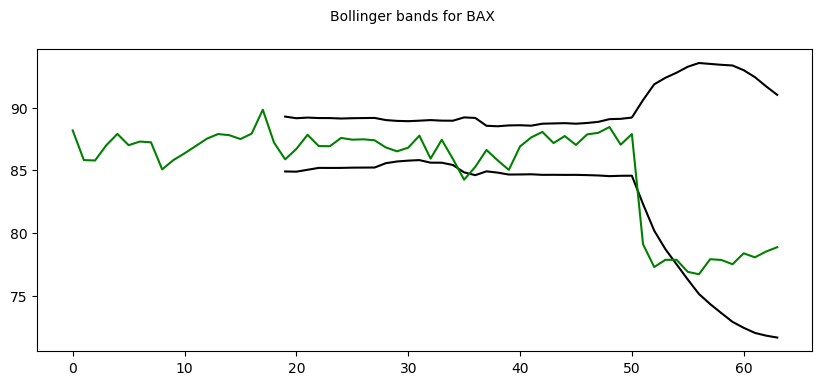

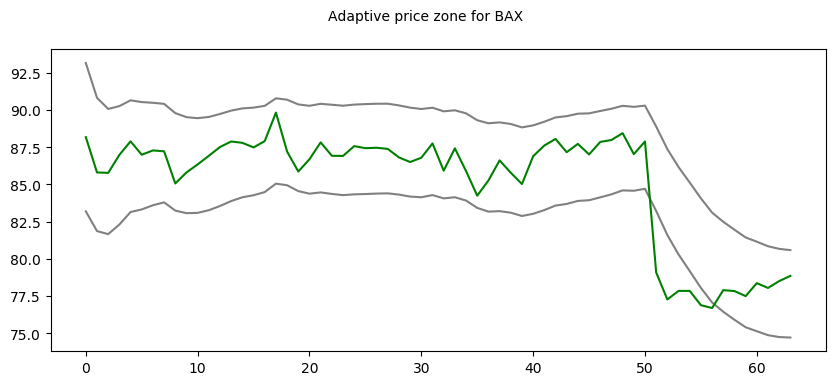

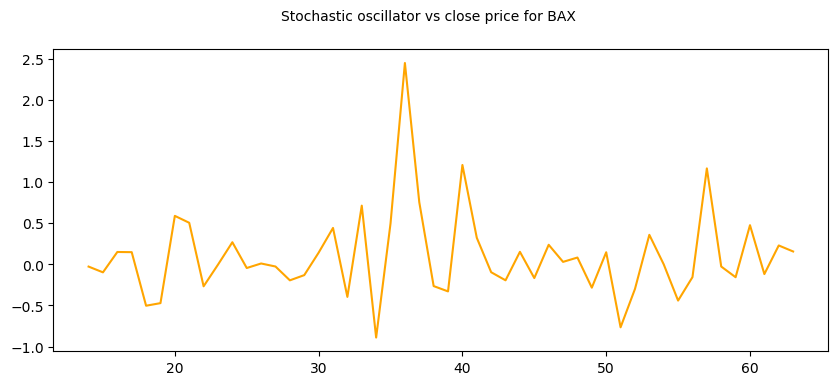

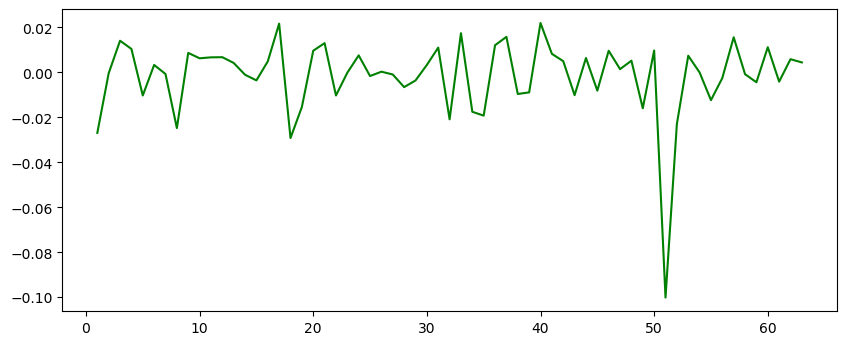

In [9]:
fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Open, high, low, close for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("S&P 500 close".format(ticker), fontsize=10)
plt.plot(day_spy_bars["close"], color="red")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent changes of S&P 500 close vs {}".format(ticker), fontsize=10)
plt.plot(day_spy_bars["close"].pct_change(), color="blue")
plt.plot(ticker_cluster["close"].pct_change(), color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Close price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("MACD vs signal for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["macd"], color="purple")
plt.plot(ticker_cluster["signal"], color="pink")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Close price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("MFI for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["mfi"], color="blue")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Bollinger bands for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Adaptive price zone for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Stochastic oscillator vs close price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["stoch"].pct_change(), color="orange")

fig = plt.figure(figsize=(10,4), dpi=100)
plt.plot(ticker_cluster["close"].pct_change(), color="green")

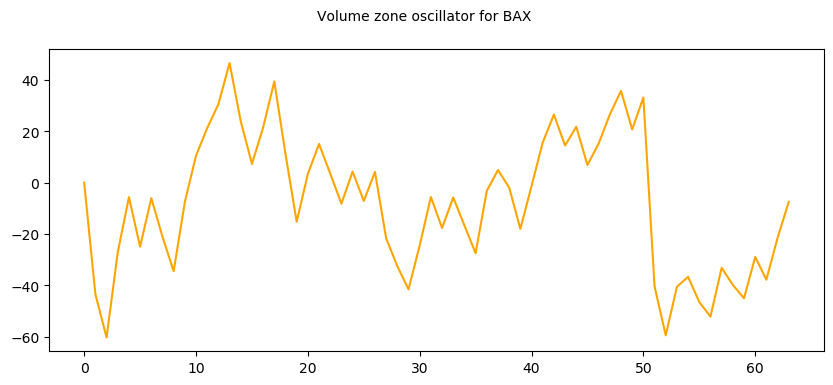

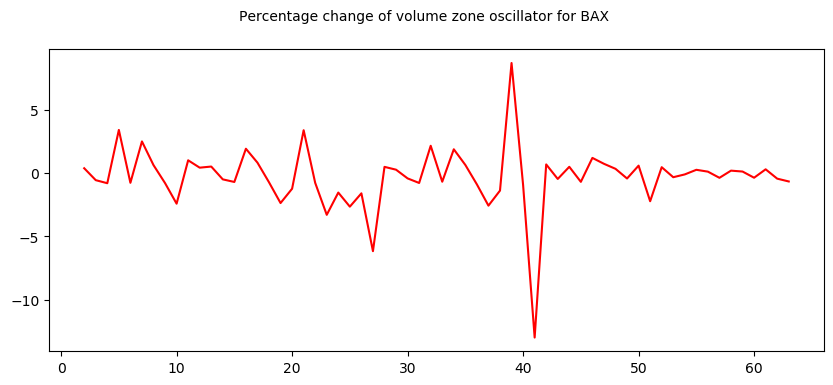

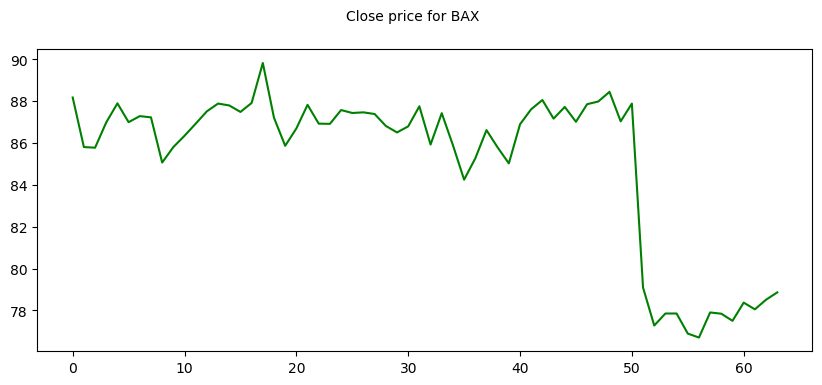

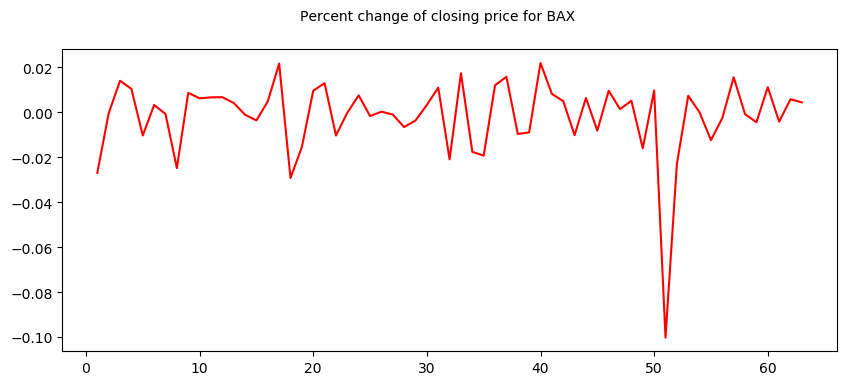

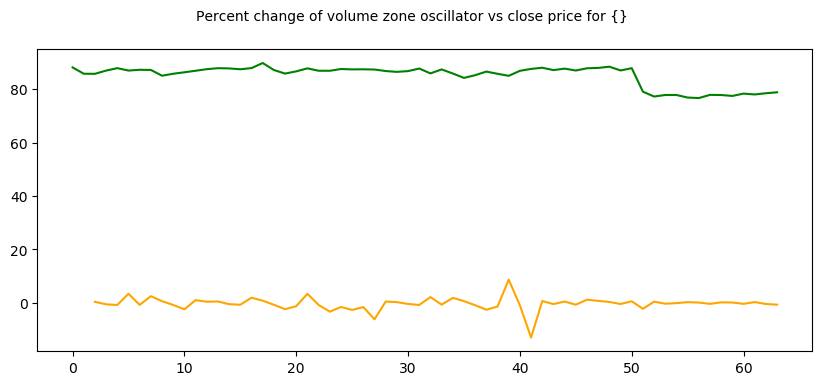

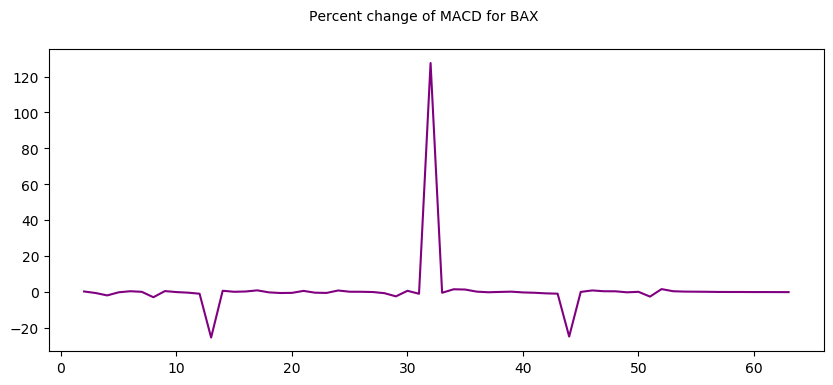

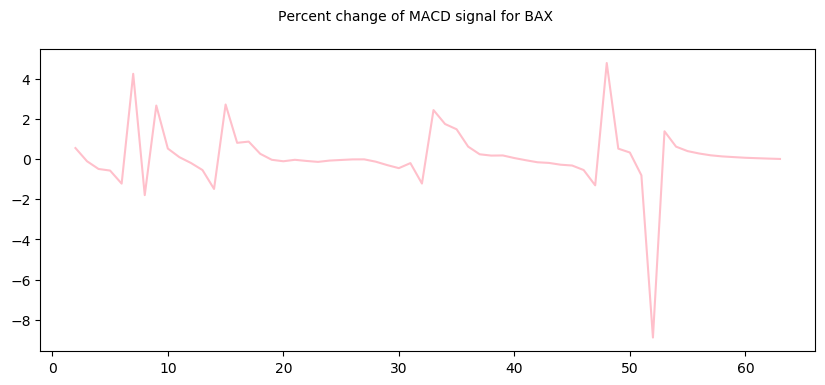

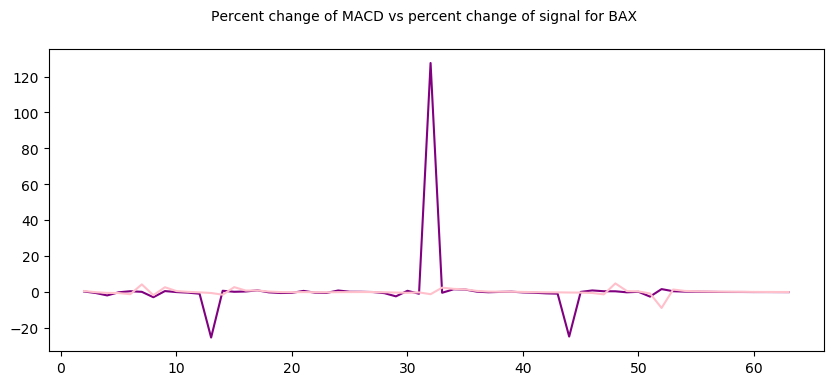

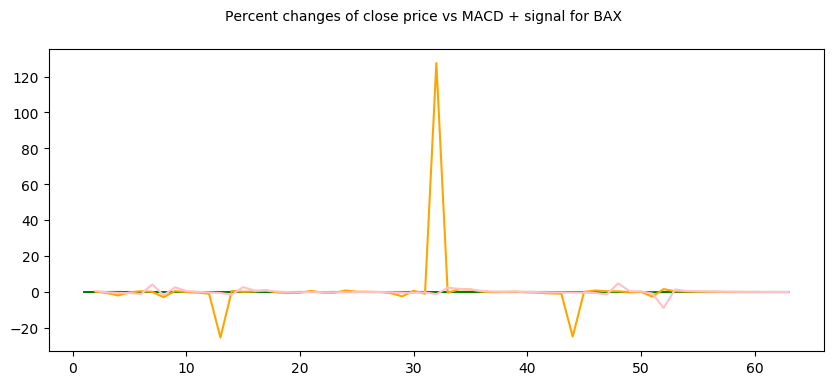

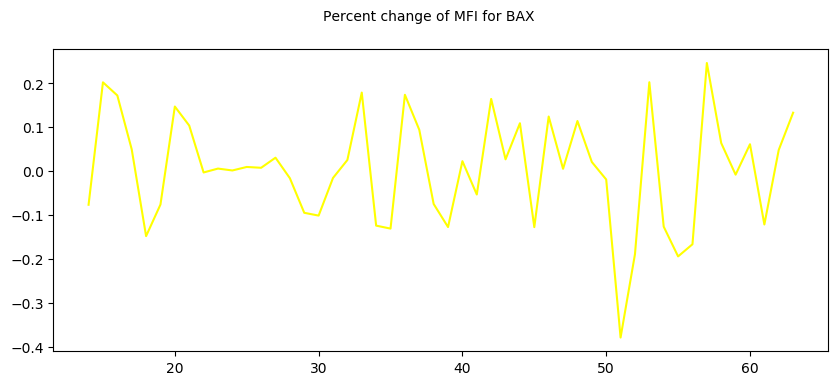

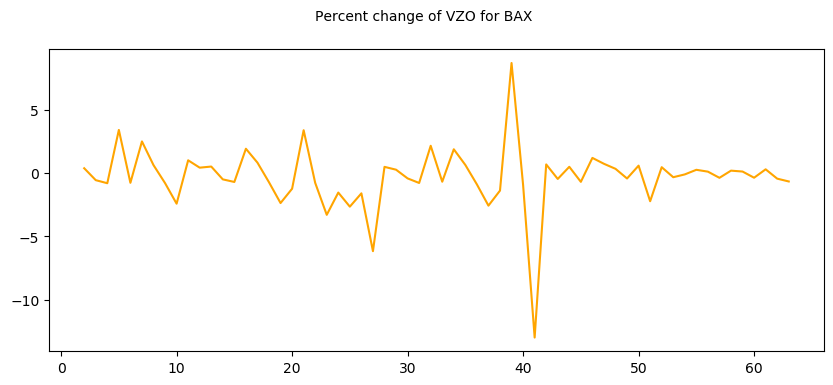

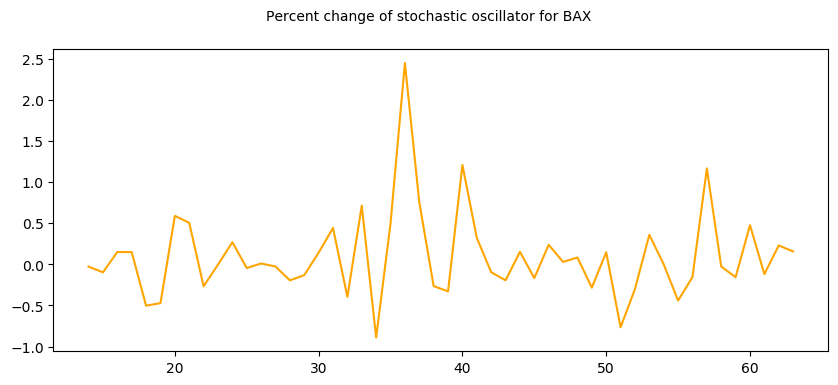

In [10]:
fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Volume zone oscillator for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["vzo"], color="orange")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percentage change of volume zone oscillator for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="red")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Close price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of closing price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"].pct_change(), color="red")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of volume zone oscillator vs close price for {}", fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")
plt.plot(ticker_cluster["close"], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of MACD for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of MACD signal for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of MACD vs percent change of signal for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent changes of close price vs MACD + signal for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"].pct_change(), color="green")
plt.plot(ticker_cluster["macd"].pct_change(), color="orange")
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of MFI for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["mfi"].pct_change(), color="yellow")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of VZO for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of stochastic oscillator for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["stoch"].pct_change(), color="orange")

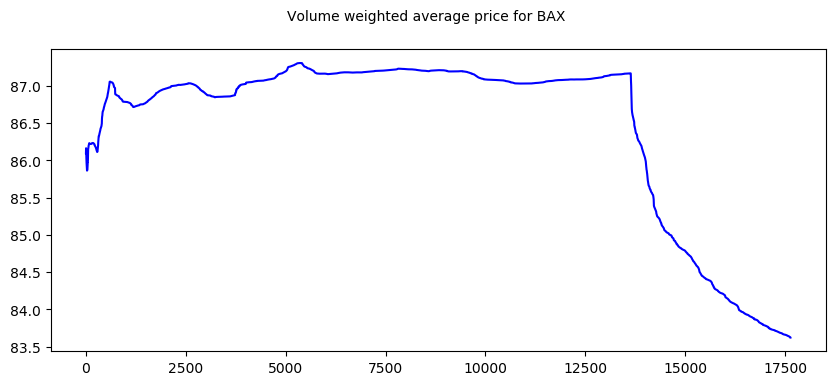

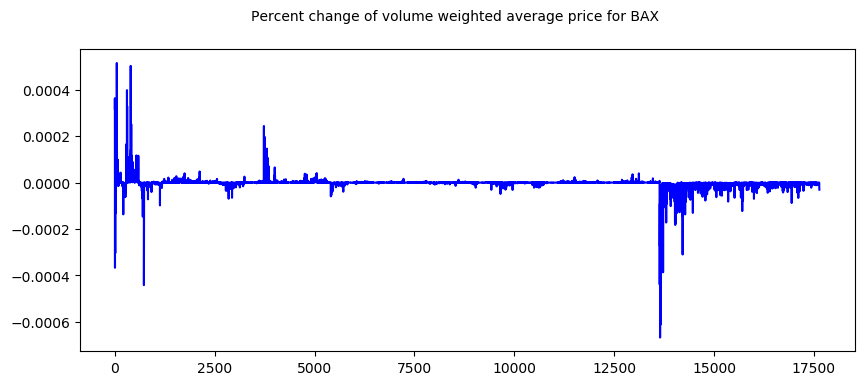

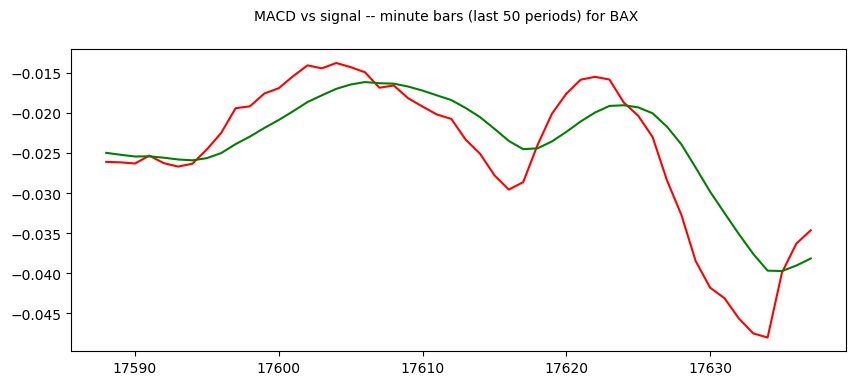

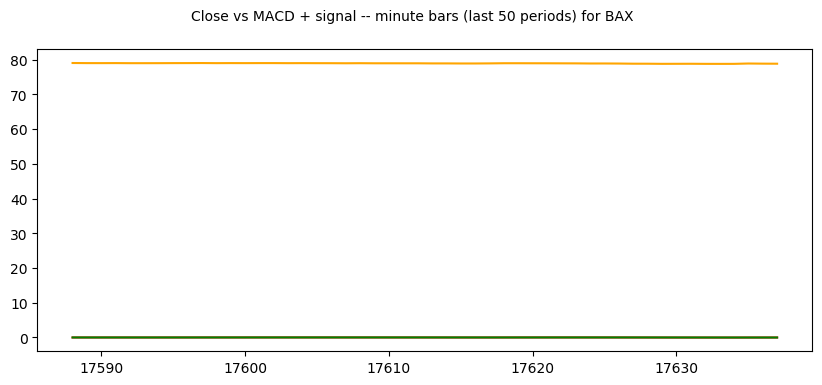

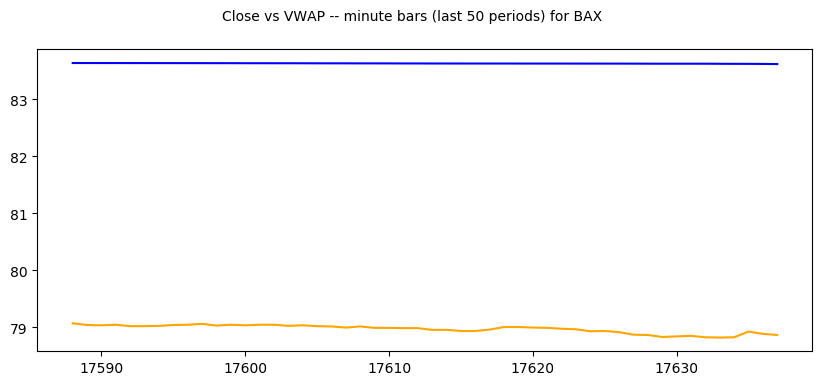

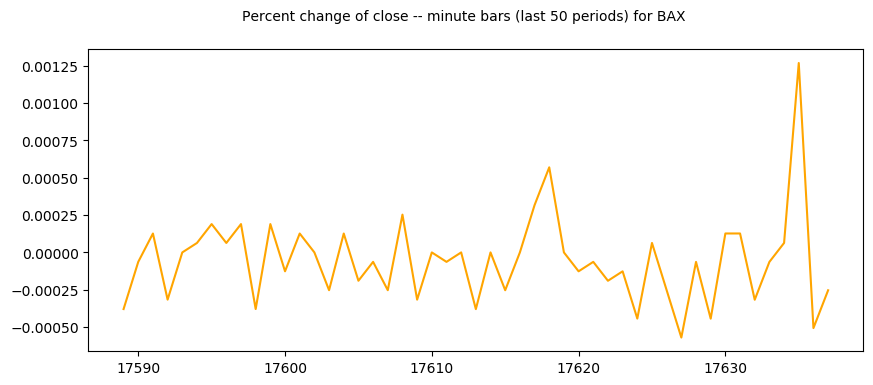

In [11]:
vwap = indicators.get_vwap(minute_bars)
minute_macd = indicators.get_macd(minute_bars)

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Volume weighted average price for {}".format(ticker), fontsize=10)
plt.plot(vwap, color="blue")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of volume weighted average price for {}".format(ticker), fontsize=10)
plt.plot(vwap.pct_change(), color="blue")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("MACD vs signal -- minute bars (last 50 periods) for {}".format(ticker), fontsize=10)
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Close vs MACD + signal -- minute bars (last 50 periods) for {}".format(ticker), fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Close vs VWAP -- minute bars (last 50 periods) for {}".format(ticker), fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(vwap.iloc[-50:], color="blue")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Percent change of close -- minute bars (last 50 periods) for {}".format(ticker), fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:].pct_change(), color="orange")

# calculate the max drawdown
# max_drawdown = max_drawdown(minute_bars["close"])
# day_bars.iloc[-50:]
# minute_bars["close"]
# day_spy_bars.iloc[-50:]
# calculate alpha and beta
# alpha = alpha(minute_bars["close"], minute_spy_bars["close"])
# beta = beta(minute_bars["close"], minute_spy_bars["close"])
# print(alpha, beta, max_drawdown)

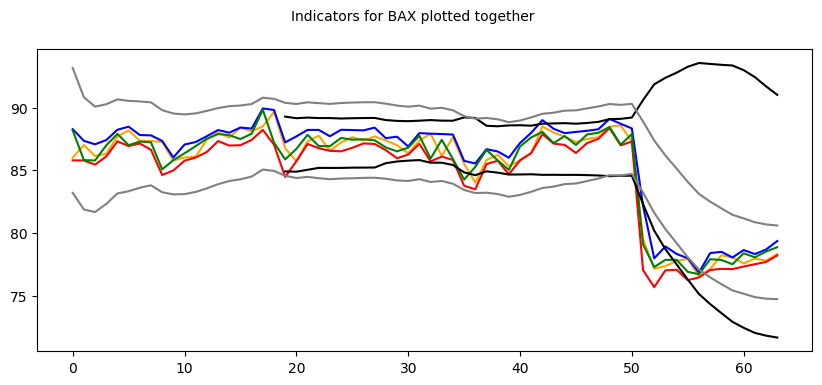

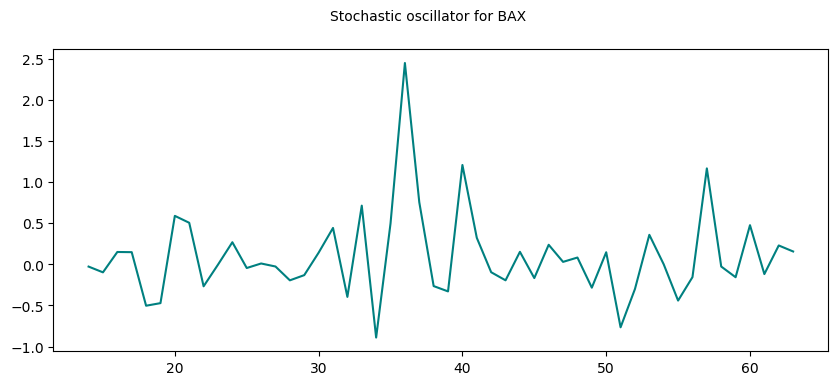

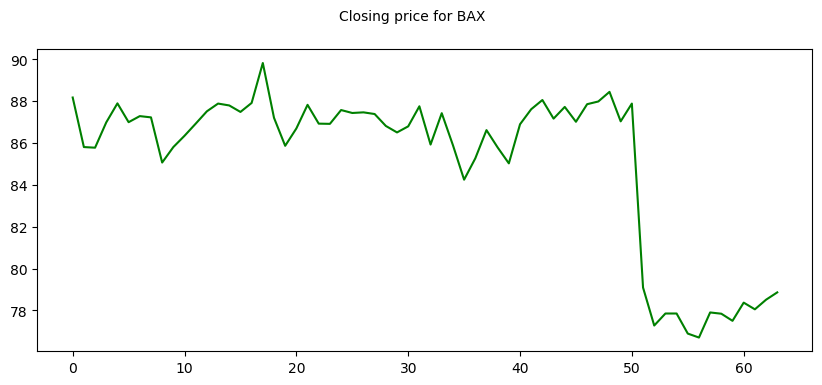

In [12]:
fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Indicators for {} plotted together".format(ticker), fontsize=10)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")
plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Stochastic oscillator for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["stoch"].pct_change(), color="teal")

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Closing price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"], color="green")

In [36]:
# Heatmap time -- had to create a separate dataframe sans date index column for this 
nd = pd.DataFrame()
nd["close"]     = ticker_cluster["close"]
nd["macd"]      = ticker_cluster["open"]
nd["signal"]    = ticker_cluster["open"]
nd["mfi"]       = ticker_cluster["open"]
nd["vzo"]       = ticker_cluster["open"]
nd["volume"]    = ticker_cluster["open"]
nd["bb_up"]     = ticker_cluster["bb_up"]
nd["bb_low"]    = ticker_cluster["bb_low"]
heatmap = go.Heatmap(
    z=nd.iloc[-50:].pct_change().corr(method='pearson').values,
    x=nd.columns,
    y=nd.columns,
    colorbar=dict(title='Pearson Coefficient'),
)
layout = go.Layout(title="Pearson correlation of indicators")
heatmap['zmax'] = 1.0
heatmap['zmin'] = -1.0
fig = go.Figure(data=[heatmap], layout=layout)
py.iplot(fig)

In [37]:
# ticker_cluster

In [38]:
# if __name__ == '__main__':
#     get_gainers()
#     print()
#     get_losers()

In [39]:
# bulls = selector.bullish_candlesticks(64, 20)

In [40]:
# bears = selector.bearish_candlesticks(64, 20)

In [41]:
# minute_bars["close"].iloc[-600:]

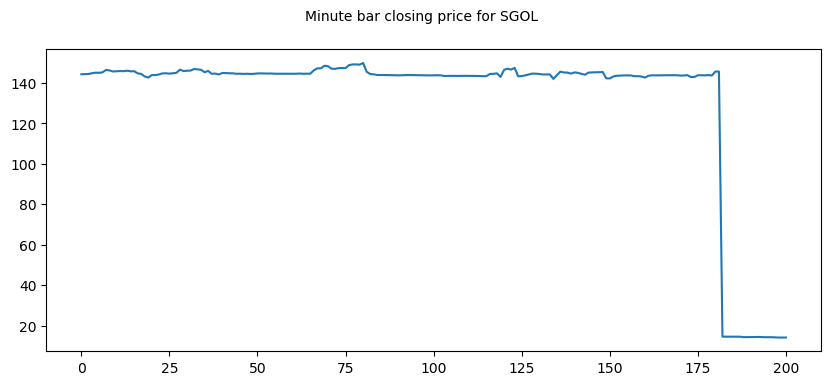

In [42]:
fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Minute bar closing price for {}".format(ticker), fontsize=10)
plt.plot(minute_bars["close"].iloc[-600:])

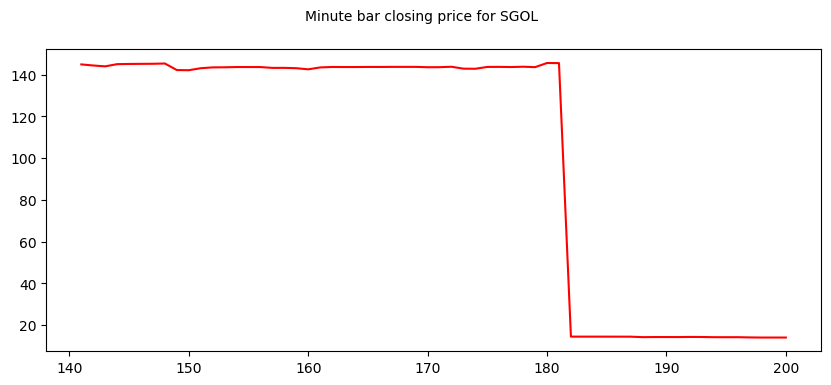

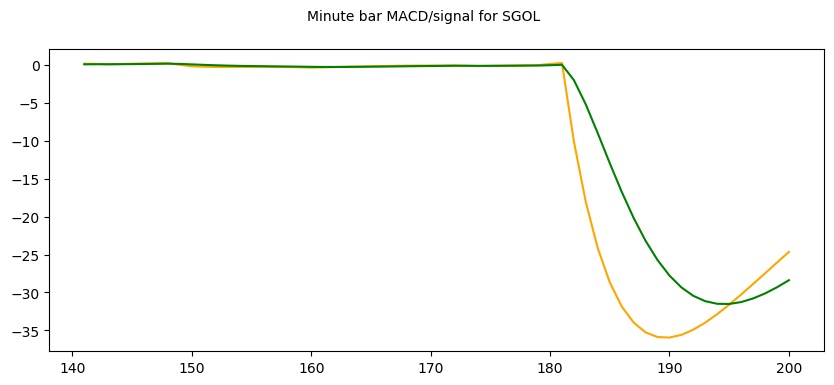

In [43]:
fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Minute bar closing price for {}".format(ticker), fontsize=10)
plt.plot(minute_bars["close"].iloc[-60:], color="red")

mmacd = indicators.get_macd(minute_bars.iloc[-600:])

fig = plt.figure(figsize=(10,4), dpi=100)
fig.suptitle("Minute bar MACD/signal for {}".format(ticker), fontsize=10)
plt.plot(mmacd["MACD"][-60:], color="orange")
plt.plot(mmacd["SIGNAL"][-60:], color="green")